#**Time Series Forecasting of U.S. Natural Gas Electricity Generation (2001–2030) Using SARIMA and Holt-Winters**

# **Project Summary**
Long-term energy planning and sustainable resource management depend on sound forecasts of electricity generation. Natural gas overtook coal in 2015 and has since become the leading source of electricity generation in the United States. Today, natural gas accounts for approximately 43% of total electricity generation, while coal contributes around 15%, highlighting a significant shift toward cleaner and more flexible energy sources.
This project applied two time series methods - **SARIMA** and **Holt-Winters (Triple Exponential Smoothing)** - to model and forecast monthly electricity generation from natural gas in the United States. The data was collected from the U.S. Energy Information Administration (EIA) over a 25-year period between January 2001 and March 2025. Both models were trained on historical data spanning January 2001 to December 2020 and evaluated over a test period from January 2021 to March 2025. Forecasts were then extended five years into the future, covering the period from April 2025 to March 2030.
Evaluation results indicate that both models effectively captured the underlying trend and seasonal patterns in the time series. The Holt-Winters model slightly outperformed SARIMA in terms of Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE), suggesting marginally higher forecasting precision.
These findings demonstrate the practical utility of SARIMA and Holt-Winters models for medium-term energy forecasting, providing valuable insights for stakeholders involved in policy making, infrastructure investment, and energy market operations. For example, in **July 2029**, both models predict electricity generation from natural gas to reach approximately **226,000 thousand megawatt-hours (226 million MWh)**, reflecting peak summer demand.
<br> <br>

---

### **More Details on Data Collection and Applied Time Series Models**

#### **Data Collection and Processing**

The primary time series used in this project is **monthly electricity generated from natural gas** (measured in **thousand megawatt-hours**). The data was retrieved from the [U.S. Energy Information Administration](https://www.eia.gov/electricity/data/browser/).

*Note: The time series of interest is **nationwide** and not specific to any individual state or region.*

---
---
#### **List of Time Series Models Developed and Evaluated in This Project**
The following time series models were developed and compared to forecast monthly electricity generation:
- **SARIMA model**
- **Holt-Winters model (i.e., Triple Exponential Smoothing)**

            Natural_gas_mwh
Date                       
2001-01-01      42388.66300
2001-02-01      37966.92700
2001-03-01      44364.41400
2001-04-01      45842.74600
2001-05-01      50934.20500
...                     ...
2024-11-01     137041.41254
2024-12-01     145365.01275
2025-01-01     156526.71341
2025-02-01     132339.57223
2025-03-01     118919.93448

[291 rows x 1 columns]



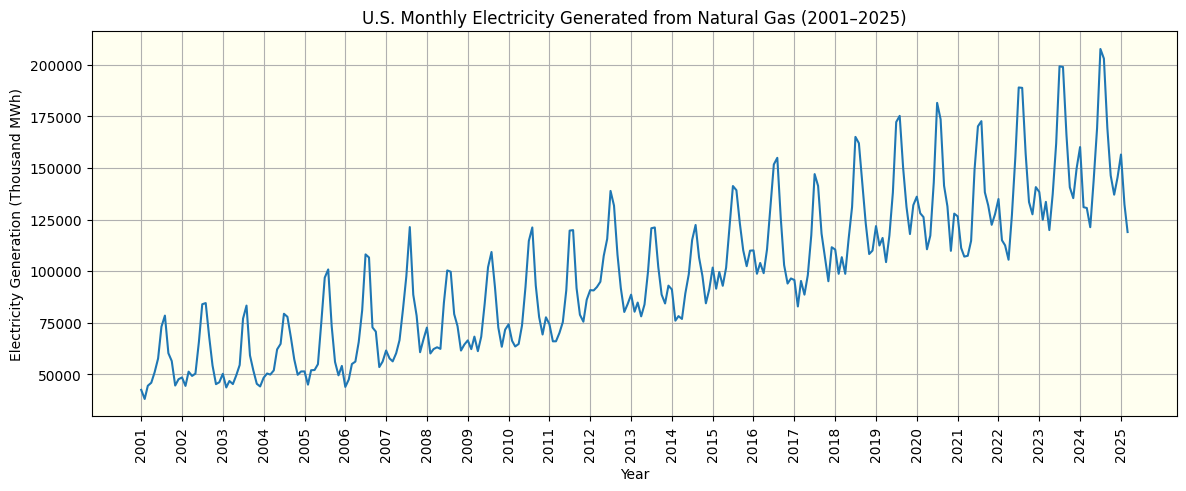

In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.width', 250)

# Load monthly electricity generation data
df = pd.read_excel('US Monthly Electricity Generation.xlsx', sheet_name='python_input')
df.set_index('Date', inplace=True)
print(df)
print()

# Visualize the trend in natural gas electricity generation over time
plt.figure(figsize=(14,5))
sns.lineplot(data=df, y='Natural_gas_mwh', x=df.index)
plt.xticks(df.index[::12], rotation=90)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlabel("Year")
plt.ylabel("Electricity Generation (Thousand MWh)")
plt.title("U.S. Monthly Electricity Generated from Natural Gas (2001–2025)")
plt.grid(True)
plt.gca().set_facecolor('ivory')
plt.show()


### **Augmented Dickey-Fuller (ADF) Test for Stationarity**
The ADF test was used to evaluate whether the time series is stationary. A low p-value (typically < 0.05) indicates stationarity.


In [ ]:
# Running the ADF test:
result = adfuller(df)
print(f"ADF Statistic: {result[0].round(4)}")
print(f"p-value: {result[1].round(4)}")
print(f"Used lag: {result[2]}")
for key, val in result[4].items():
    print(f"Significance Level: {key} → Critical Value: {val.round(4)}")


ADF Statistic: -0.374
p-value: 0.9143
Used lag: 14
Significance Level: 1% → Critical Value: -3.4543
Significance Level: 5% → Critical Value: -2.8721
Significance Level: 10% → Critical Value: -2.5724


### Interpretation of the ADF Test:
The ADF test results indicate that the time series is **not stationary**..

---
---


### **Performing Additive Seasonal Decomposition of the Natural Gas-Based Electricity Generation Time Series**

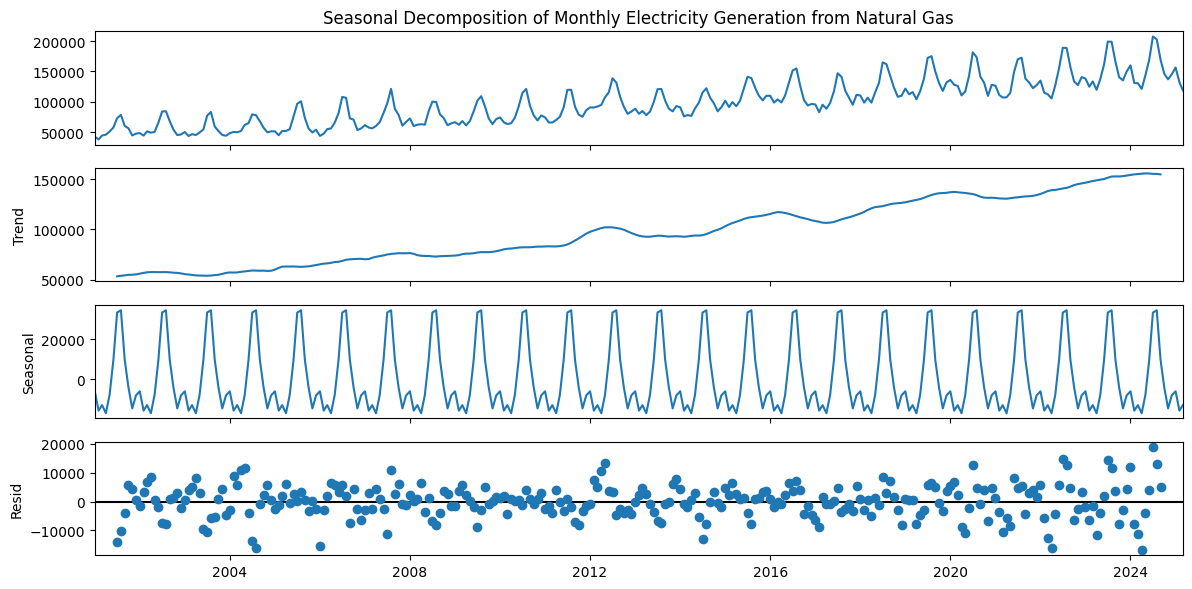

In [ ]:
result = seasonal_decompose(df['Natural_gas_mwh'], model='additive', period=12)

# Plot the components
fig = result.plot()
fig.set_size_inches(12, 6)
fig.axes[0].set_title("Seasonal Decomposition of Monthly Electricity Generation from Natural Gas")
plt.tight_layout()
plt.show()


### Key Insights from Seasonal Decomposition Components

- **Seasonality**: The seasonal component remains constant over time, implying that an **additive seasonal model** is appropriate.

- **Trend**: The trend component shows a gradual linear increase, indicating that the time series is non-stationary.

- **Differencing**:
  - Apply **first-order non-seasonal differencing** (d = 1) to remove the linear trend.
  - Apply **seasonal differencing** (D = 1) to eliminate seasonal effects.

- **Residuals**: The residual component exhibits no clear patterns or structures, suggesting that the residuals behave like **white noise**.

- **Variance Stability**: No signs of heteroskedasticity are present, so a **log transformation to stabilize variance is not necessary**.



---
---
# **Train-Test Split for Model Development & Evaluation**

To evaluate the forecasting performance of time series mode, includingas SARIMA and Holt-Winte models, the dataset was split into two subsets:

- **Training Sample (82%)**: All data points before January 2021 were used to train the models.
- **Test Sample (18%)**: Data from January 2021 onward were held out for testing and evaluating the model’s forecast accurarios.


In [2]:
# Train-Test Split Prior to SARIMA Model Development
df_train = df[df.index < '2021-01-01'] # Contains 82% of total observations
df_test = df[df.index >= '2021-01-01'] # Contains 18% of total observations

print(f"Total Length of Sample: {len(df)}")
print(f"Length of Training Sample: {len(df_train)}")
print(f"Length of Test Sample: {len(df_test)}")
print()

print("Training Sample:")
print(df_train)
print()

print("Test Sample (first-5):")
print(df_test.head(5))

print("Test Sample (end-5):")
print(df_test.tail(5), '\n')


Total Length of Sample: 291
Length of Training Sample: 240
Length of Test Sample: 51

Training Sample:
            Natural_gas_mwh
Date                       
2001-01-01      42388.66300
2001-02-01      37966.92700
2001-03-01      44364.41400
2001-04-01      45842.74600
2001-05-01      50934.20500
...                     ...
2020-08-01     173644.41702
2020-09-01     141397.45495
2020-10-01     131412.57892
2020-11-01     109810.78026
2020-12-01     127863.17223

[240 rows x 1 columns]

Test Sample (first-5):
            Natural_gas_mwh
Date                       
2021-01-01     126529.59847
2021-02-01     111182.91493
2021-03-01     107018.71133
2021-04-01     107416.26793
2021-05-01     114675.79155
Test Sample (end-5):
            Natural_gas_mwh
Date                       
2024-11-01     137041.41254
2024-12-01     145365.01275
2025-01-01     156526.71341
2025-02-01     132339.57223
2025-03-01     118919.93448 



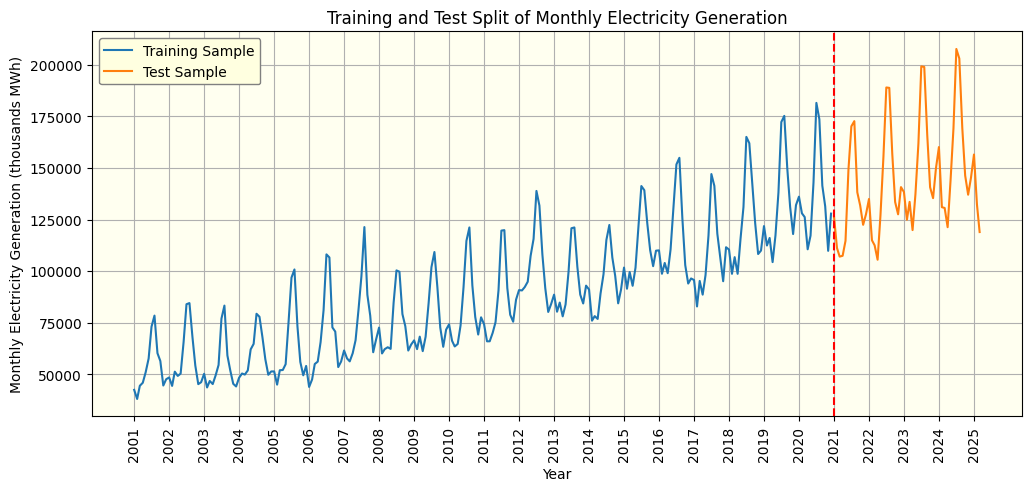

In [3]:
# Plotting Monthly Electricity Price Over Time for Training and Test Subsamples:
plt.figure(figsize=(12, 5))
sns.lineplot(df_train, x=df_train.index, y='Natural_gas_mwh', label="Training Sample")
sns.lineplot(df_test, x=df_test.index, y='Natural_gas_mwh', label="Test Sample")
plt.axvline(x=pd.to_datetime('2021-01-01'), color='red', linestyle='--', linewidth=1.5)

plt.title("Training and Test Split of Monthly Electricity Generation")
plt.xlabel("Year")
plt.ylabel("Monthly Electricity Generation (thousands MWh)")
plt.xticks(df.index[::12], rotation=90)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().set_facecolor('ivory')
legend = plt.legend(framealpha=1)
legend.get_frame().set_edgecolor('gray')
legend.get_frame().set_facecolor('lightyellow')
plt.grid(True)
plt.show()


### **Time Series Transformation Plots**

The plots below show:

1. **Original Series:** Monthly electricity generation from natural gas (shows trend and seasonality).  
2. **First-Order Differenced:** Removes trend but seasonal pattern remains.  
3. **Seasonally Differenced:** Removes both trend and seasonality, making the series more stationary.

These transformations help prepare the data for SARIMA modeling.


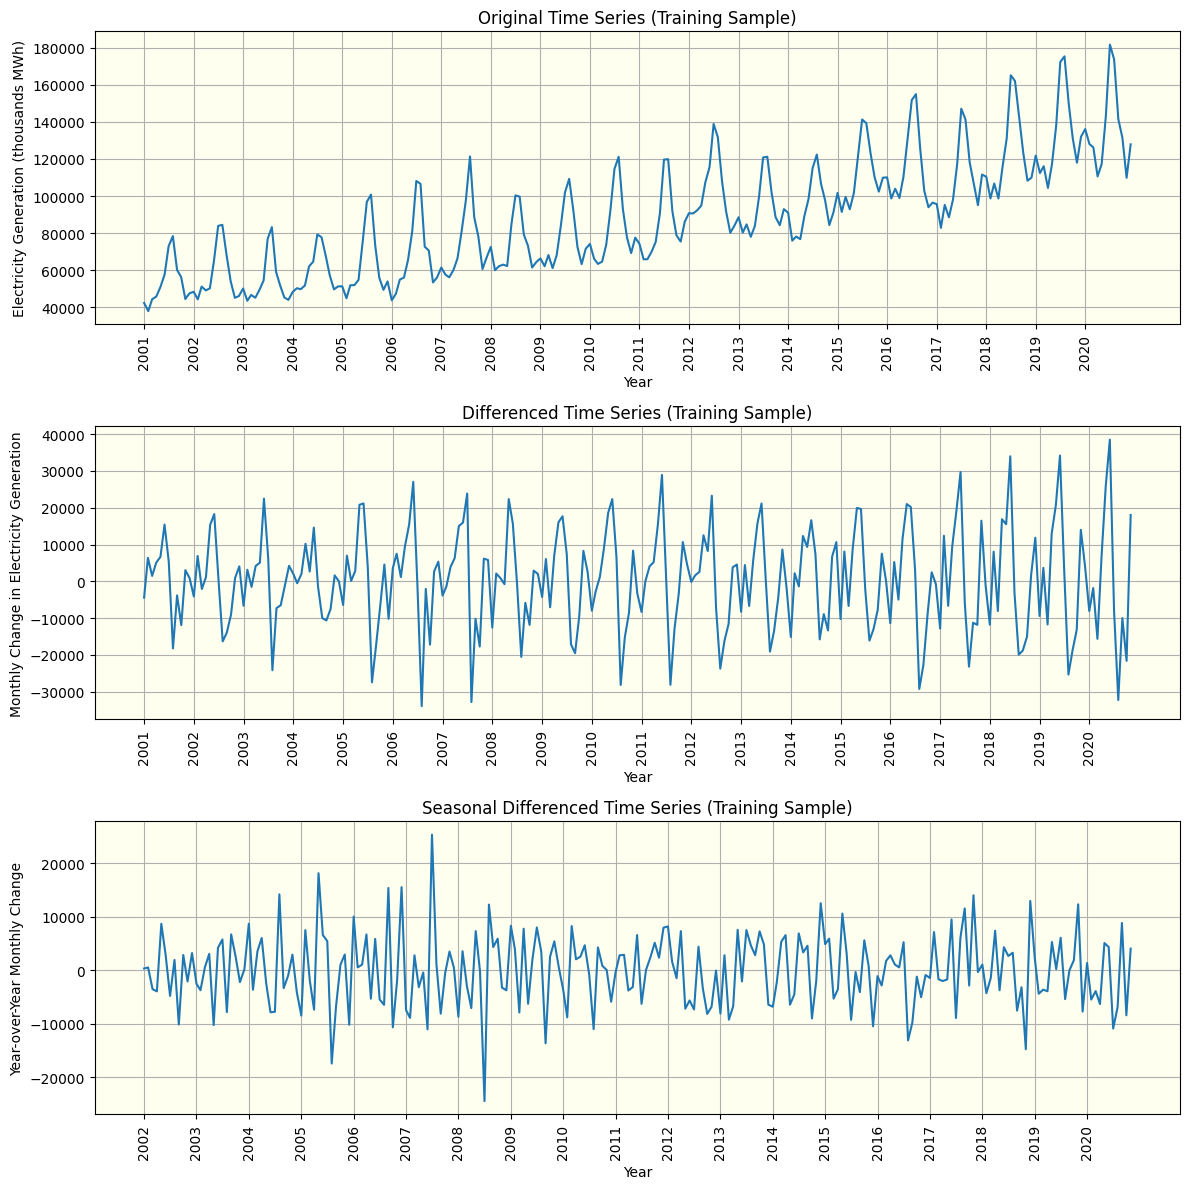

In [ ]:
# Plot of the Original and Differenced Time Series
plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)

# 1. Original Time Series
sns.lineplot(data=df_train, y=df_train['Natural_gas_mwh'], x=df_train.index)
plt.xticks(df_train.index[::12], rotation=90)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.title("Original Time Series (Training Sample)")
plt.xlabel("Year")
plt.ylabel("Electricity Generation (thousands MWh)")
plt.gca().set_facecolor('ivory')
plt.grid(True)

# 2. First-Order Differenced Time Series (Non-Seasonal)
plt.subplot(3, 1, 2)
df_diff= df_train.diff().dropna()
sns.lineplot(data=df_diff, y=df_diff['Natural_gas_mwh'], x=df_diff.index)
plt.xticks(df_diff.index[::12], rotation=90)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.title("Differenced Time Series (Training Sample)")
plt.xlabel("Year")
plt.ylabel("Monthly Change in Electricity Generation")
plt.gca().set_facecolor('ivory')
plt.grid(True)

# 3. Seasonal Differenced Time Series (12-Month Lag)
plt.subplot(3, 1, 3)
seasonal_diff= df_train.diff().diff(periods=12).dropna()
sns.lineplot(data=seasonal_diff, y=seasonal_diff['Natural_gas_mwh'], x=seasonal_diff.index)
plt.title("Seasonal Differenced Time Series (Training Sample)")
plt.xticks(seasonal_diff.index[::12], rotation=90)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlabel("Year")
plt.ylabel("Year-over-Year Monthly Change")
plt.grid(True)
plt.gca().set_facecolor('ivory')
plt.tight_layout()
plt.show()


### **Interpretation of the Differencing Plots Above for Stationarity**

- The **first-order differenced (d=1) time series** still exhibits a repeating seasonal pattern, indicating that **seasonality remains** after removing the trend.

- The **seasonally differenced (D=1) time series** (after applying both first-order and seasonal differencing) shows that the **seasonal pattern has been removed**, and the fluctuations appear **more stable and random** over time.

- This suggests that the resulting time series is **stationary**, which is a necessary condition for fitting a **SARIMA model**.


---
---

# **Applying the SARIMA Model to Monthly Electricity Generation Data**
The **Seasonal Autoregressive Integrated Moving Average (SARIMA)** model is an advanced extension of the ARIMA model. It incorporates seasonal components and captures complex patterns—such as trends and periodic fluctuations—in time series data. SARIMA is widely used in fields like economics, energy, and meteorology for forecasting time-dependent phenomena. A key assumption of the model is that the data must be stationary, which often requires differencing techniques to remove trends and seasonality.
<p>

In this project, two techniques were used to identify the optimal parameters `(p, d, q, P, D, Q)` of the SARIMA model:

---

### **1. Custom Grid Search**  
An iterative algorithm explores combinations of SARIMA parameters `(p, d, q)` and `(P, D, Q)` using the training dataset. For each candidate model,
- **AIC** (Akaike Information Criterion) and **SSE** (Sum of Squared Errors) were computed to assess model fit.  
- The **Ljung-Box test** was applied to ensure residuals are uncorrelated (p-value > 0.10).

The model with the lowest AIC—and the lowest SSE is selected. This iterative algorithm was adapted from an R-based framework developed by Dr. William Thistleton and Dr. Tura Sadigov from the State University of New York Polytechnic Institute.

---

### **2. `auto_arima()` from `pmdarima`**  
This function automatically selects the best SARIMA model based on **AIC/BIC**, while internally handling differencing and seasonal component selection.


---
---
## **ACF and PACF Analysis for Identifying Potential SARIMA Model Order (p, d, q)(P, D, Q)[12]**
Autocorrelation (ACF) and partial autocorrelation (PACF) plots were used to identify the presence of trend and seasonality in a time series. These plots  help select differencing required to transform the series into a stationary form before developing the SARIMA model.

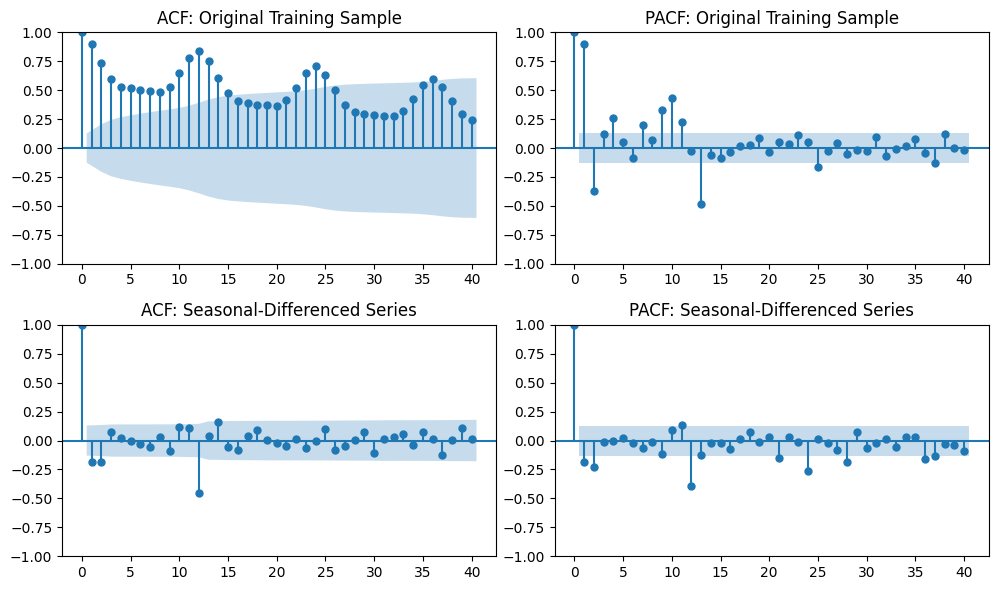

In [ ]:
# Plotting ACF and PACF for the training sample:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# ACF and PACF of original series
plot_acf(df_train['Natural_gas_mwh'].dropna(), lags=40, ax=axes[0, 0])
axes[0, 0].set_title("ACF: Original Training Sample")
plot_pacf(df_train['Natural_gas_mwh'].dropna(), lags=40, ax=axes[0, 1])
axes[0, 1].set_title("PACF: Original Training Sample")

# ACF and PACF of seasonal-differenced series
seasonal_diff = df_train['Natural_gas_mwh'].diff().diff(12).dropna()
plot_acf(seasonal_diff, lags=40, ax=axes[1, 0])
axes[1, 0].set_title("ACF: Seasonal-Differenced Series")
plot_pacf(seasonal_diff, lags=40, ax=axes[1, 1], method='ywm')
axes[1, 1].set_title("PACF: Seasonal-Differenced Series")

plt.tight_layout()
plt.show()


### **Key Findings from ACF and PACF Analysis of Monthly Electricity Generation**

The ACF and PACF plots of both the original and seasonally-differenced series provide insights into the appropriate parameters for the SARIMA model.

---

#### **ACF Observations**
- The original series shows a **gradual decline** at the initial lags, indicating a **trend** — suggesting the need for **non-seasonal differencing** (`d = 1`).
- **Significant spikes at lags 12 and 24** point to **strong seasonality**, implying **seasonal differencing** is needed (`D = 1`).
- After differencing, **spikes at lag 1** confirm **short-term autocorrelation**, supporting **MA(1)** (`q = 1`).
- A **clear spike at lag 12** after seasonal differencing suggests the need for a **seasonal MA(1)** component (`Q = 1`).

---

#### **PACF Observations**
- The original PACF plot shows **strong spikes at lags 1 and 2**, followed by a sharp drop, indicating a possible **AR(1) or AR(2)** process (`p = 1 or 2`).
- After seasonal differencing, **moderate spikes at lags 1 and 2** still support **non-seasonal AR terms**.
- **Spikes at lags 12 and 24** suggest potential **seasonal AR terms**, implying **P = 1 or 2**.

---

#### **Recommended Parameter Ranges Based on ACF and PACF**
> **SARIMA(p = 1–2, d = 1, q = 1–2) × (P = 1–2, D = 1, Q = 1) [12]**

These findings guide the model selection and grid search process used to identify the best-fit SARIMA model for forecasting monthly electricity generation from natural gas.


---
---
### **1. Custom Grid Search for Finding Optimal SARIMA Model Parameters**

In [ ]:
# Searching for the SARIMA Model with Optimal Parameters
seasonal_period = 12

print("p d q P D Q s  AIC            SSE            p-value")
print("-" * 50)

best_model = None
best_aic = np.inf
best_sse = np.inf
best_summary = ""

for p in range(0, 3):
    for d in range(0, 2):
        for q in range(0, 3):
            for P in range(0, 3):
                for D in range(0, 2):
                    for Q in range(0, 3):
                        try:
                            model = SARIMAX(df_train['Natural_gas_mwh'],
                                            order=(p, d, q),
                                            seasonal_order=(P, D, Q, seasonal_period))
                            fit = model.fit(disp=False)
                            resid = fit.resid

                            # Ljung-Box test
                            lb = acorr_ljungbox(resid, lags=[int(np.log(len(resid)))], return_df=True)
                            pval = lb['lb_pvalue'].iloc[0]

                            sse = np.sum(resid ** 2)
                            aic = fit.aic

                            print(f"{p} {d} {q} {P} {D} {Q} {seasonal_period}  AIC={aic: .4f}  SSE={sse:.4f}  p-value={pval:.4f}")

                            # Storing best model if conditions are met
                            if (pval > 0.10) and (aic < best_aic or (aic == best_aic and sse < best_sse)):
                                best_model = fit
                                best_aic = aic
                                best_sse = sse
                                best_summary = f"Best Model: SARIMA({p},{d},{q}) × ({P},{D},{Q})[{seasonal_period}]\nAIC={aic:.4f}, SSE={sse:.4f}, p-value={pval:.4f}"

                        except Exception as e:
                            print(f"Model ({p},{d},{q}) × ({P},{D},{Q}) failed: {e}")

print("\n" + "="*50)
if best_model:
    print("✅", best_summary)
else:
    print("⚠️ No suitable model found with p-value > 0.10")


p d q P D Q s  AIC            SSE            p-value
--------------------------------------------------
0 0 0 0 0 0 12  AIC= 6176.23  SSE=2091130151479.5586  p-value=0.0000
0 0 0 0 0 1 12  AIC= 6048.49  SSE=710463076836.8131  p-value=0.0000
0 0 0 0 0 2 12  AIC= 6043.36  SSE=383273406683.9282  p-value=0.0000
0 0 0 0 1 0 12  AIC= 4868.53  SSE=60553100563.9487  p-value=0.0000
0 0 0 0 1 1 12  AIC= 4871.54  SSE=60551520292.0826  p-value=0.0000
0 0 0 0 1 2 12  AIC= 4873.58  SSE=60418233711.9629  p-value=0.0000
0 0 0 1 0 0 12  AIC= 5180.94  SSE=61444382739.1029  p-value=0.0000
0 0 0 1 0 1 12  AIC= 5184.62  SSE=60827389285.6170  p-value=0.0000
0 0 0 1 0 2 12  AIC= 5182.67  SSE=60857840226.0928  p-value=0.0000
0 0 0 1 1 0 12  AIC= 4870.25  SSE=60551668262.7727  p-value=0.0000
0 0 0 1 1 1 12  AIC= 4873.41  SSE=60548123187.5701  p-value=0.0000
0 0 0 1 1 2 12  AIC= 4839.82  SSE=55564354795.6252  p-value=0.0000
0 0 0 2 0 0 12  AIC= 5188.02  SSE=60799557221.1476  p-value=0.0000
0 0 0 2 0 1 12  AIC= 

The custom grid search algorithm identified **SARIMA(1, 1, 1) × (0, 1, 1)[12]** as the best-fit model, with the following performance metrics:
- **AIC**: 4576.52  
- **SSE**: 1.0592 × 10¹⁰  
- **Ljung-Box p-value**: 0.9347


---
---
### **2. auto_arima() Method from the pmdarima Library for Automatic SARIMA Model Selection**

In [ ]:
# Since the current time series exhibits both trend and seasonality, d and D are set to 1 in the auto_arima() model below.
model = auto_arima(df_train['Natural_gas_mwh'], seasonal=True, m=12, d=1, D=1,  trace=True, stepwise=True) # Q=2 found non-significant. Hence, max_Q=1


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=4591.690, Time=1.17 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4650.664, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4608.668, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4581.362, Time=0.29 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=4641.947, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=4592.303, Time=0.15 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=4592.281, Time=0.45 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=4606.958, Time=0.08 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=4594.174, Time=0.59 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=4584.697, Time=0.09 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.57 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=4579.453, Time=0.40 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=4639.226, Time=0.04 sec
 ARIMA(0,1,2)(1,1,1)[12]             : AIC=4590.031, Time=0.27 sec
 ARIMA(0,1,2)(0,1,2)[12]


The `auto_arima()` function selected **ARIMA(0,1,2)(0,1,1)[12]** as the best model according to the lowest AIC = 4579.4537.


## **Selecting the Best-Fit SARIMA Model**
The custom grid search method identified **ARIMA(1,1,1)(0,1,1)[12]** as the best-fit model with an AIC of **4576.52**, while the `auto_arima()` function selected **ARIMA(0,1,2)(0,1,1)[12]** with an AIC of **4579.45**.  
Since the former yields a lower AIC, **ARIMA(1,1,1)(0,1,1)[12]** was selected as the final model.


In [7]:
# Fitting the best-fit SARIMA model:
sarimax_best_model= SARIMAX(df_train['Natural_gas_mwh'], order=(1, 1, 1), seasonal_order=(0, 1, 1, 12))
fit_sarima = sarimax_best_model.fit()
print(fit_sarima.summary())


                                     SARIMAX Results                                      
Dep. Variable:                    Natural_gas_mwh   No. Observations:                  240
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -2284.262
Date:                            Fri, 18 Jul 2025   AIC                           4576.525
Time:                                    01:05:41   BIC                           4590.225
Sample:                                01-01-2001   HQIC                          4582.053
                                     - 12-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8738      0.037     23.900      0.000       0.802       0.945
ma.L1         -1.0000      0.091   

### **The general equation of the SARIMA(1,1,1)(0,1,1)[12] model fitted above is:**

$$(1 - 0.8738B)(1 - B)(1 - B^{12})X_t = (1 - 1.0000B)(1 - 0.6026B^{12})Z_t$$

Where:
- X<sub>t</sub> is the **predicted value** of the time series (monthly electricity generation from natural gas) at time t,
- B is the **backshift operator:**
 $$BX_t = X_{t-1} \    or   \  B^{12}X_t = X_{t-12} \ $$
- Z<sub>t</sub> is the **white noise error term**, assumed to follow a normal distribution:

$$ Z_t \sim \mathcal{N}(0,\sigma^2) \quad \text{with} \quad \sigma^2 = 3.13 \times 10^7 $$


<br>

The equation above is expanded using the backshift operator as follows:

$$
\mathbf{X_t} = 1.8738\mathbf{X_{t-1}} - 0.8738\mathbf{X_{t-2}} + \mathbf{X_{t-12}} - 1.8738\mathbf{X_{t-13}} + 0.8738\mathbf{X_{t-14}} + \mathbf{Z_t} - \mathbf{Z_{t-1}} - 0.6026\mathbf{Z_{t-12}}
$$



Where:
- X<sub>t−1</sub>, X<sub>t−2</sub>, X<sub>t−12</sub>, ... are the **observed values** of the time series from the previous month, two months ago, twelve months ago, and so on.
- Z<sub>t−1</sub> represents the **non-seasonal moving average (MA(1))** component.
- Z<sub>t−12</sub> represents the **seasonal moving average (SMA(1))** component at lag 12, which captures seasonal shocks repeating every 12 periods (e.g., months).


### **Diagnostic Plots for the SARIMAX Model**
This section generates diagnostic plots after fitting the SARIMAX model with the selected optimal parameters. These plots help assess key assumptions, such as the independence of residuals over time and their normality.


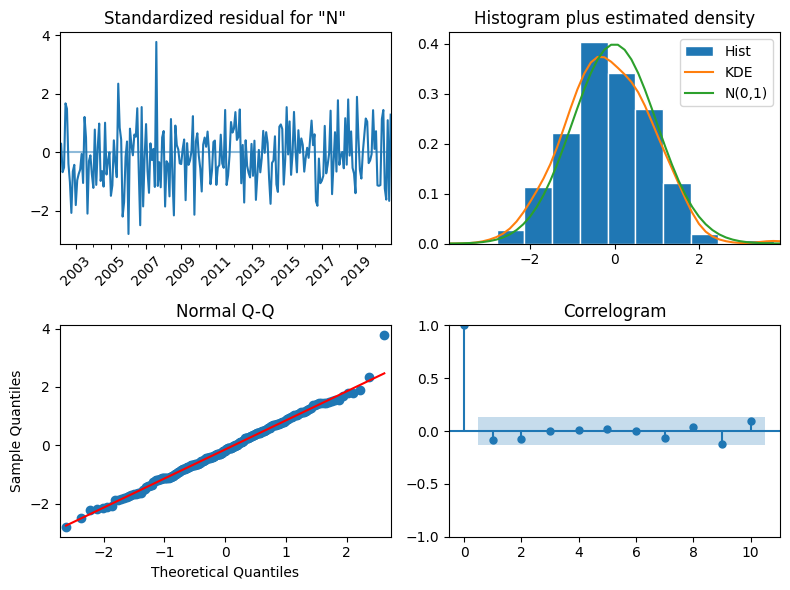

In [ ]:
fig = fit_sarima.plot_diagnostics(figsize=(8, 6))
axes = fig.get_axes()
axes[0].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


### Inference from the Diagnostic Plots:
- **Standardized Residuals Plot**  
  The residuals are fairly stable and fluctuate around zero, indicating they behave like white noise.

- **Histogram + KDE Plot**  
  The distribution of residuals closely resembles a normal distribution, as reflected by the histogram and the kernel density curve aligning with the theoretical normal curve.

- **Normal Q-Q Plot**  
  Most data points align with the reference line, suggesting that the residuals are approximately normally distributed.

- **Correlogram (ACF of Residuals)**  
  All spikes fall within the 95% confidence intervals (blue shaded bounds), confirming the absence of significant autocorrelation in the residuals and supporting the adequacy of the model. This is also supported by the Ljung-Box test results shown in the SARIMA model output.


---
---

### **SARIMA Model Prediction & Visualization for the Test Set and Future Forecast**

The SARIMA model was used to predict monthly electricity generation from natural gas for two distinct periods:

- **Out-of-sample test period**: 51 observations spanning from **January 2021 to March 2025**, used to evaluate the model's predictive accuracy on unseen data.
- **Forecast period**: 60 future observations from **April 2025 to March 2030**, providing a five-year projection beyond the available dataset.

In total, the SARIMA model generated **111 monthly predictions**, combining both test and forecast periods.  
The predicted values were then visualized alongside the actual training and test samples to assess the model’s performance and long-term forecasting behavior.

Actual and Predicted Monthly Electricity Generation from Natural Gas (January 2021 – March 2030):
            Natural_gas_mwh     Predicted
2021-01-01     126529.59847  132761.55881
2021-02-01     111182.91493  123335.74993
2021-03-01     107018.71133  126564.16048
2021-04-01     107416.26793  115435.56224
2021-05-01     114675.79155  125914.61908
...                     ...           ...
2029-11-01              NaN  165820.06026
2029-12-01              NaN  178762.00524
2030-01-01              NaN  183531.01285
2030-02-01              NaN  173992.15879
2030-03-01              NaN  177121.79584

[111 rows x 2 columns] 



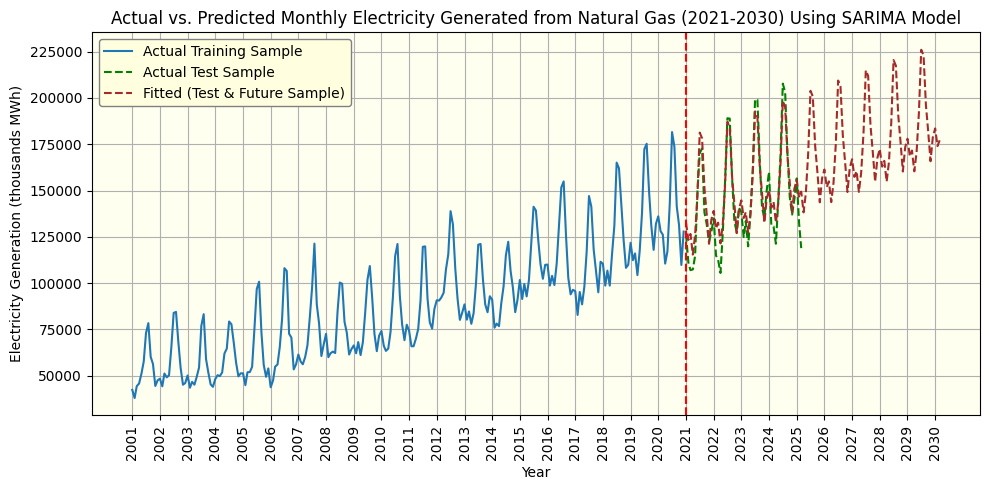

In [8]:
# Generating Predictions for the Test and Forecast Periods
predicted  = fit_sarima.predict(start=len(df_train), end=len(df)+59).round(5) # Alternative method to predict monthly electricity generation for the test period (51 observations) and forecast period (60 observations over 5 years): predicted = fit.forecast(111).round(5)
predicted.index = pd.date_range(start= "2021-01-01", end= "2030-03-01", freq='MS')

# Combining the test sample with the predicted values into a new DataFrame called "combined_SARIMA"
combined_SARIMA = pd.concat([df_test, predicted], axis=1)
combined_SARIMA = combined_SARIMA.rename(columns={'predicted_mean': "Predicted"})
print("Actual and Predicted Monthly Electricity Generation from Natural Gas (January 2021 – March 2030):")
print(combined_SARIMA, '\n')

# Ploting the observed vs predicted values for the test sample:
plt.figure(figsize=(10, 5))
sns.lineplot(df_train, x=df_train.index, y=df_train['Natural_gas_mwh'], label="Actual Training Sample")
sns.lineplot(data= df_test, x= df_test.index, y='Natural_gas_mwh',color='green', linestyle="--", label="Actual Test Sample")
sns.lineplot(data=combined_SARIMA, x=combined_SARIMA.index, y='Predicted', label='Fitted (Test & Future Sample)', linestyle='--', color='brown')

# Adding vertical line at 2021-01-01:
plt.axvline(x=pd.to_datetime('2021-01'), color='red', linestyle='--', linewidth=1.5)

plt.title("Actual vs. Predicted Monthly Electricity Generated from Natural Gas (2021-2030) Using SARIMA Model")
plt.xlabel("Year")
date = pd.date_range(start="2001-01", end="2030-03", freq='MS')
plt.xticks(date[::12], rotation=90)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.ylabel("Electricity Generation (thousands MWh)")
plt.tight_layout()
legend = plt.legend(framealpha=1)
legend.get_frame().set_edgecolor('gray')
legend.get_frame().set_facecolor('lightyellow')
plt.gca().set_facecolor('ivory')
plt.grid(True)
plt.show()


### **Inference from the plot:**
<p align="justify">
The plot shows that the SARIMA model effectively captured the patterns in the unseen test sample, particularly during the high-demand summer months. This strong performance can be attributed to the model’s ability to incorporate both trend and seasonality in the data. Additionally, the model was used to generate a five-year forecast beyond the available dataset, covering the period from April 2025 to March 2030.
<p>

### **Calculating Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE) of the SARIMA Model on the Test Sample:**

In [ ]:
# Calculating RMSE and MAE
pred_test_SARIMA = combined_SARIMA[:51]
mse_test_SARIMA = mean_squared_error(pred_test_SARIMA['Natural_gas_mwh'], pred_test_SARIMA['Predicted'])
rmse_test_SARIMA = round(np.sqrt(mse_test_SARIMA), 2)
mae_test_SARIMA = round(mean_absolute_error(pred_test_SARIMA['Natural_gas_mwh'], pred_test_SARIMA['Predicted']), 2)

# Printing the results
print(f"RMSE of the SARIMA Model on the Test Sample: {rmse_test_SARIMA}")
print(f"MAE of the SARIMA Model on the Test Sample: {mae_test_SARIMA}")


RMSE of the SARIMA Model on the Test Sample: 9450.76
MAE of the SARIMA Model on the Test Sample: 7353.0


# **Applying the Holt-Winters Model to Monthly Electricity Generation Data**
<p align="justify">
The Holt-Winters model, also known as Triple Exponential Smoothing, is an extension of the exponential smoothing technique designed to capture three key components of a time series: level (the baseline value), trend (the direction or slope), and seasonality (regular periodic fluctuations). This makes it particularly well-suited for forecasting time series data that exhibits both trend and seasonal patterns. However, despite its strengths, the Holt-Winters model does not incorporate exogenous variables (i.e., external regressors). In other words, it generates forecasts based solely on the historical values of the target variable, without accounting for the influence of potential external factors. In cases where such external variables significantly contribute to the time series, alternative models like SARIMA with exogenous regressors (SARIMAX) or Facebook Prophet may provide better predictive performance.
<p>




In [4]:
# Fitting The Holt-Winters model:
HW_model = ExponentialSmoothing(df_train['Natural_gas_mwh'], trend='add',  seasonal='add', seasonal_periods= 12) # Additive seasonality ('seasonal="add"') was selected because it resulted in a lower AIC compared to multiplicative seasonality ('seasonal="mul"').
fit_HW = HW_model.fit()
print(fit_HW.summary())


                       ExponentialSmoothing Model Results                       
Dep. Variable:          Natural_gas_mwh   No. Observations:                  240
Model:             ExponentialSmoothing   SSE                     7010043170.709
Optimized:                         True   AIC                           4157.593
Trend:                         Additive   BIC                           4213.283
Seasonal:                      Additive   AICC                          4160.688
Seasonal Periods:                    12   Date:                 Fri, 18 Jul 2025
Box-Cox:                          False   Time:                         01:02:05
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.6378945                alpha                 True
smoothing_trend          

The general equation of the additive Holt-Winters - Triple Exponential Smoothing is expressed as:  
$$
F_{t+k} = L_t + k \times T_t + S_{t+k-12}
$$
where:
- F<sub>t+k</sub>: represents the forecasted value for 𝑘 periods ahead from time 𝑡.  
- L<sub>t</sub>: level component at time t  
- k: forecast horizon, or the number of steps ahead to predict from time t  
- T<sub>t</sub>: trend component at time t  
- S<sub>t+k−12</sub>: seasonal component at time t + k − 12  


## Key Findings from the Holt-Winters Exponential Smoothing Model
- The model **moderately weights recent observations**  
  *(Smoothing level, αlpha = 0.638)*

- **Trend changes slowly** over time  
  *(Smoothing trend, betha ≈ 0.00001)*

- The model **accounts for seasonal patterns with moderate influence**  
  *(Smoothing seasonal, gamma = 0.259)*

- It starts from a **high initial level** of ~53,002 MWh, with a **positive monthly trend** of ~ 318 MWh

- **Seasonal fluctuations vary considerably**, with the largest effects occurring during the **summer months** (June to September; i.e., `seasons.5` to `seasons.8`), mainly due to increased electricity demand.


---
---

## **Holt-Winters Model Prediction & Visualization for the Test Set and Future Forecast**

Similar to the SARIMA model, the Holt-Winters model was used to predict monthly electricity generation from natural gas across two distinct periods:

- **Out-of-sample test period**: 51 observations spanning from **January 2021 to March 2025**  
- **Forecast period**: 60 future observations from **April 2025 to March 2030**

The predicted values were plotted alongside the actual training and test data to evaluate the model’s accuracy and long-term forecasting performance.

Actual and Predicted Monthly Electricity Generation from Natural Gas (January 2021 – March 2030):
            Natural_gas_mwh      Predicted
2021-01-01     126529.59847  129870.949730
2021-02-01     111182.91493  118978.445477
2021-03-01     107018.71133  122574.888072
2021-04-01     107416.26793  114733.443081
2021-05-01     114675.79155  128998.743180
...                     ...            ...
2029-11-01              NaN  148067.251859
2029-12-01              NaN  160625.994834
2030-01-01              NaN  164285.513062
2030-02-01              NaN  153393.008810
2030-03-01              NaN  156989.451404

[111 rows x 2 columns] 



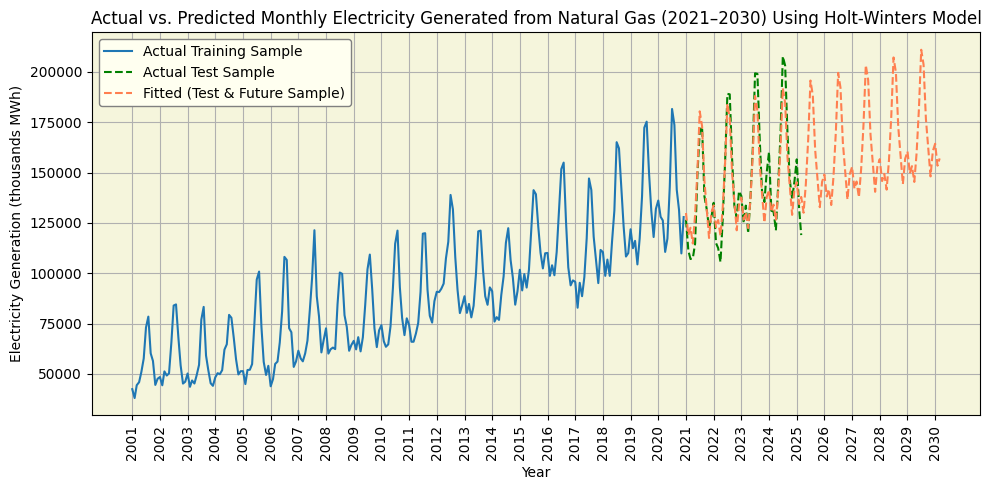

In [6]:
# Predicting all the out-of-sample test data (51 observations) plus five years beyond (through March 2030; 60 observations):
forecast_HW = fit_HW.forecast(111)
forecast_HW.index = pd.date_range(start= "2021-01-01", end= "2030-03-01", freq='MS')

# Combining the test sample with the predicted values into a new DataFrame called "combined_HW"
combined_HW = pd.concat([df_test, forecast_HW], axis=1)
combined_HW = combined_HW.rename(columns={0: 'Predicted'})
print("Actual and Predicted Monthly Electricity Generation from Natural Gas (January 2021 – March 2030):")
print(combined_HW, '\n')

# Plotting for observed vs fitted values:
plt.figure(figsize=(10, 5))
sns.lineplot(df_train, x=df_train.index, y=df_train['Natural_gas_mwh'], label="Actual Training Sample")
sns.lineplot(data= df_test, x= df_test.index, y= df_test['Natural_gas_mwh'],color='green', linestyle="--", label="Actual Test Sample")
sns.lineplot(data=combined_HW, x= combined_HW.index, y='Predicted', label='Fitted (Test & Future Sample)', linestyle='--', color='coral')

plt.title("Actual vs. Predicted Monthly Electricity Generated from Natural Gas (2021–2030) Using Holt-Winters Model")
plt.xlabel("Year")
plt.ylabel("Electricity Generation (thousands MWh)")
date = pd.date_range(start="2001-01", end="2030-03", freq='MS')
plt.xticks(date[::12], rotation=90)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.tight_layout()
legend = plt.legend(framealpha=1)
legend.get_frame().set_edgecolor('gray')
legend.get_frame().set_facecolor('ivory')
plt.gca().set_facecolor('beige')
plt.grid(True)
plt.show()


### **Calculating RMSE and MAE of the Holt-Winters Model on the Test Sample:**

In [ ]:
# Calculate RMSE and MAE
pred_test_HW = combined_HW[:51]
mse_test_HW = mean_squared_error(pred_test_HW['Natural_gas_mwh'], pred_test_HW['Predicted'])
rmse_test_HW = round(np.sqrt(mse_test_HW), 2)
mae_test_HW = round(mean_absolute_error(pred_test_HW['Natural_gas_mwh'], pred_test_HW['Predicted']), 2)

print(f"RMSE of the Holt-Winters Model on the Test Sample: {rmse_test_HW}")
print(f"MAE of the Holt-Winters Model on the Test Sample: {mae_test_HW}")

RMSE of the Holt-Winters Model on the Test Sample: 9082.86
MAE of the Holt-Winters Model on the Test Sample: 7181.61


# **Plotting the RMSE and MAE Metrics for the SARIMA and Holt-Winters Models.**

                 RMSE      MAE
SARIMA        9450.76  7353.00
Holt-Winters  9082.86  7181.61


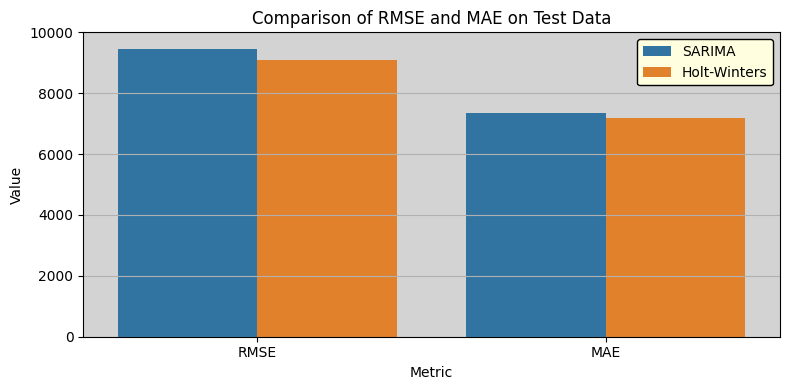

In [ ]:
data = pd.DataFrame({'Metric': ['RMSE', 'MAE', 'RMSE', 'MAE'], 'Value': [rmse_test_SARIMA, mae_test_SARIMA, rmse_test_HW, mae_test_HW], 'Model': ['SARIMA', 'SARIMA', 'Holt-Winters', 'Holt-Winters']
})
print(pd.DataFrame({'RMSE': [rmse_test_SARIMA, rmse_test_HW], 'MAE': [mae_test_SARIMA,  mae_test_HW]}, index= ['SARIMA', 'Holt-Winters']))

plt.figure(figsize=(8, 4))
sns.barplot(data=data, x='Metric', y='Value', hue='Model')

plt.title("Comparison of RMSE and MAE on Test Data")
plt.xlabel("Metric")
plt.ylim(0, 10000)
plt.grid(axis='y')
legend = plt.legend(framealpha=1)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_facecolor('lightyellow')
plt.gca().set_facecolor('lightgray')
plt.tight_layout()
plt.show()


### **Inference from the Barplot of RMSE and MAE:**
The comparison of RMSE and MAE on the test dataset indicates that the Holt-Winters (Triple Exponential Smoothing) model **slightly outperformed** the SARIMA model in terms of prediction accuracy, with approximately **7–9% lower error values**. Although both models exhibited similar performance, the lower RMSE and MAE associated with the Holt-Winters model suggest it provided a **marginally better fit** for modeling electricity generation from natural gas in this context.

---
---

## **Static and Interactive Plots of Actual vs. Forecasted Natural Gas Electricity Generation (SARIMA & Holt-Winters)**
The plots below illustrate the actual (observed) and forecasted monthly electricity generation from natural gas, covering the test period (January 2021 – March 2025) and extended projections through March 2030. The forecasts were generated using the SARIMA and Holt-Winters (Triple Exponential Smoothing) models.

### **(A) Static Plot of Actual vs. Forecasted Natural Gas Electricity Generation**

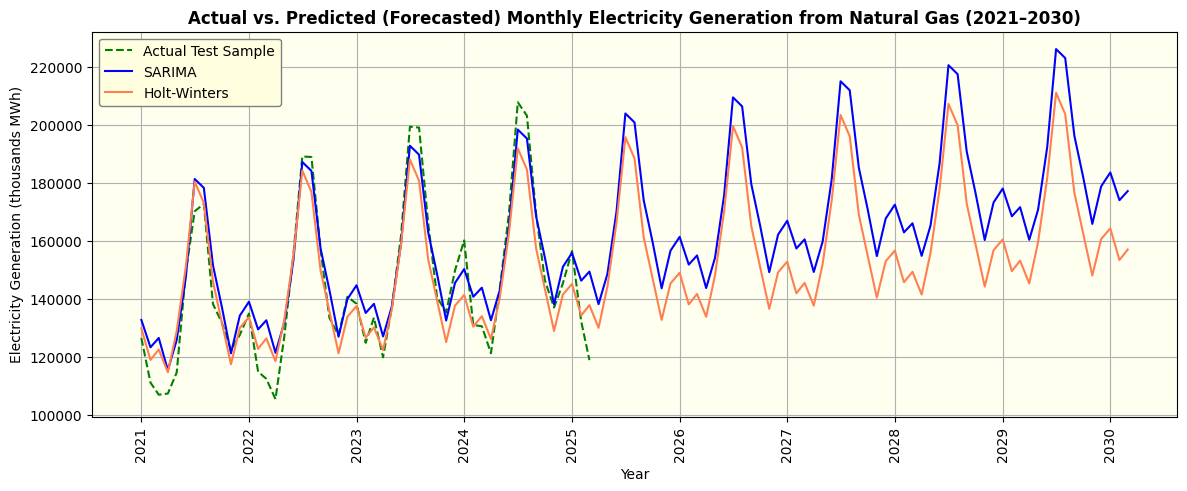

In [ ]:
plt.figure(figsize=(14, 5))
sns.lineplot(data= df_test, x=df_test.index, y=df_test['Natural_gas_mwh'],label="Actual Test Sample", linestyle="--", color= 'green')
sns.lineplot(data= combined_SARIMA, x=combined_SARIMA.index, y=combined_SARIMA['Predicted'],  label='SARIMA', color= 'blue')
sns.lineplot(data= combined_HW, x=combined_HW.index, y=combined_HW['Predicted'], label='Holt-Winters', color= 'coral')

plt.title('Actual vs. Predicted (Forecasted) Monthly Electricity Generation from Natural Gas (2021–2030)', fontweight='bold')
plt.xlabel("Year")
plt.xticks(combined_SARIMA.index[::12], rotation=90)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.ylabel("Electricity Generation (thousands MWh)")
legend = plt.legend(framealpha=1)
legend.get_frame().set_edgecolor('gray')
legend.get_frame().set_facecolor('lightyellow')
plt.gca().set_facecolor('ivory')
plt.grid(True)
plt.show()


### **(B) Interactive Plot of Actual vs. Forecasted Natural Gas Electricity Generation**

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_test.index, y=df_test['Natural_gas_mwh'], mode='lines', name='Actual', line=dict(color='green', dash='dash')))
fig.add_trace(go.Scatter(x=combined_SARIMA.index, y=combined_SARIMA['Predicted'], mode='lines', name='SARIMA', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=combined_HW.index, y=combined_HW['Predicted'], mode='lines', name='Holt-Winters', line=dict(color='coral')))

# Update layout
fig.update_layout(
    title='Actual vs. Predicted (Forecasted) Monthly Electricity Generation from Natural Gas (2021–2030)',
    xaxis_title='Year',
    yaxis_title='Electricity Generation (thousands MWh)',
    title_font=dict(size=18),
    font=dict(family='Arial', size=14),
    hovermode='x unified'
)

fig.show()


## **Conclusions & Suggestions for Future Work**
### **Conclusions**
The primary objective of this project was to apply a time series forecasting technique to model and predict monthly electricity generation from natural gas in the United States. To accomplish this objective, two time series models-SARIMA and Holt-Winters, were developed and compared using data from the U.S. EIA spanning a 25-year period from January 2001 to March 2025. The modling comparison results indicated that the Holt-Winters model slightly outperformed the SARIMA in terms. Model comparison results indicated that the Holt-Winters model had similar performance, as measured by RMSE and MAE.
<br>
The findings from this project can support decision-makers and energy planners in developing long-term strategies related to infrastructure investment, resource allocation, and operational planning in the energy sector. For instance, both models forecast an average electricity generation of approximately **218,000 thousand MWh (218 million MWh)** for the peak summer month of July 2029.

### **Recommendations for Future Work**
While this study focused on natural gas, electricity in the U.S. is generated from multiple energy sources such as coal, nuclear, wind, and solar. **For future work**, it is recommended to extend this analysis by developing a **multivariate time series model** that predicts electricity generation from multiple energy sources, enabling a more comprehensive understanding of the national electricity supply mix.
One possible extension of this work is to incorporate **external factors**—such as fuel prices or policy changes—into the forecasting models. Time series techniques like SARIMAX and Facebook Prophet with regressors are well-suited for modeling such relationships, offering deeper insights into the drivers of electricity generation trends.
<br>
